In [ ]:
!pip install datasets

In [ ]:
import gc
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator

class DataGenerator(Sequence):
    def __init__(self, x_data, y_data, batch_size, shuffle=True, augment=False):
        self.x_data = x_data
        self.y_data = y_data
        self.batch_size = batch_size
        self.augment = augment
        self.shuffle = shuffle

        self.indexes = np.arange(len(self.x_data))
        if self.shuffle:
            np.random.shuffle(self.indexes)

        if self.augment:                        # data augmentation with zoom/horizontal flip/ random rotation to 20° and moving the image
            self.datagen = ImageDataGenerator(
                rotation_range=20,
                width_shift_range=0.2,
                height_shift_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True,
                fill_mode='nearest'
            )

    def __len__(self):
        return int(np.floor(len(self.x_data) / self.batch_size))

    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size: (index + 1) * self.batch_size]
        x_batch = self.x_data[batch_indexes]
        y_batch = self.y_data[batch_indexes]
        return x_batch, y_batch

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)




In [ ]:
from datasets import load_dataset
import numpy as np
ds = load_dataset("pcuenq/oxford-pets")
image_shape= 224

In [ ]:
ds_train = ds["train"]
ds

DatasetDict({
    train: Dataset({
        features: ['path', 'label', 'dog', 'image'],
        num_rows: 7390
    })
})

In [ ]:
image = ds["train"][4]["image"]["bytes"]
type(image) # image is type bytes so i'm going to use PIL to convert bytes to JPEG

bytes

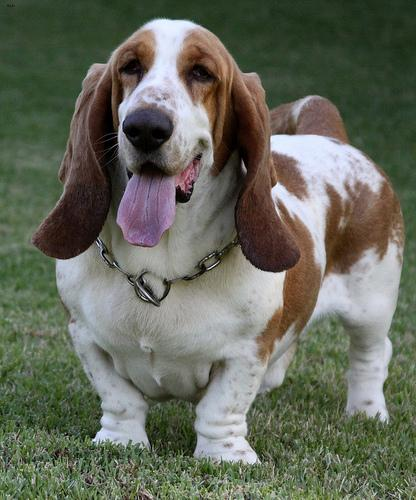

(416, 500)


In [ ]:
from PIL import Image
import io
image = ds["train"][4]["image"]["bytes"]
old_Imageshow = Image.open(io.BytesIO(image))

display(old_Imageshow)
print(old_Imageshow.size)   # size of image is random

In [ ]:
def resize_image(example, size=(image_shape, image_shape)):     #convert all iamge to iamge_shape X image_shape pixel using .resize (96x96 for example)

    image = Image.open(io.BytesIO(example["image"]["bytes"]))

    if image.mode in ['RGBA', 'P', 'L']:
        image = image.convert('RGB')


    image_resized = image.resize(size)
    image_array = np.array(image_resized) / 255.0  # Normalize to [0, 1]

    byte_io = io.BytesIO()
    image_resized.save(byte_io, format='JPEG')
    byte_io.seek(0)


    example["image"]["bytes"] = byte_io.read()

    return example
ds_resize = ds_train.map(resize_image)

(224, 224)
JPEG


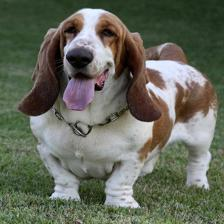

In [ ]:
image = ds_resize[4]["image"]["bytes"]
Imageshow = Image.open(io.BytesIO(image))

print(Imageshow.size)
print(Imageshow.format)
display(Imageshow)      # dataset is resized and named ds_resize

In [ ]:
from sklearn.model_selection import train_test_split
images = []
labels = []
isdog = []

for i in range(7390):
    image = Image.open(io.BytesIO(ds_resize[i]["image"]["bytes"]))

    label = ds_resize[i]["label"]
    dog = ds_resize[i]["dog"]
    images.append(np.array(image))    # cast PIL.image into numpy array
    labels.append(label)
    isdog.append(int(dog))


del ds_resize       # delete the ds_resize after using it so we save memory
gc.collect()


12408

In [ ]:
occurrences = {}

for id in labels:
  if id in occurrences:
    occurrences[id] += 1
  else:
    occurrences[id] = 1

print(occurrences)
class_breeds=list(occurrences.keys())
print(list(occurrences.keys()))
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
breed_class= label_encoder.fit_transform(list(occurrences.keys()))
print(breed_class)
print(len(breed_class))
labels = label_encoder.transform(labels)
print(labels)

{'Siamese': 200, 'Birman': 200, 'shiba inu': 200, 'staffordshire bull terrier': 191, 'basset hound': 200, 'Bombay': 200, 'japanese chin': 200, 'chihuahua': 200, 'german shorthaired': 200, 'pomeranian': 200, 'beagle': 200, 'english cocker spaniel': 200, 'american pit bull terrier': 200, 'Ragdoll': 200, 'Persian': 200, 'Egyptian Mau': 200, 'miniature pinscher': 200, 'Sphynx': 200, 'Maine Coon': 200, 'keeshond': 200, 'yorkshire terrier': 200, 'havanese': 200, 'leonberger': 200, 'wheaten terrier': 200, 'american bulldog': 200, 'english setter': 200, 'boxer': 200, 'newfoundland': 200, 'Bengal': 200, 'samoyed': 200, 'British Shorthair': 200, 'great pyrenees': 200, 'Abyssinian': 200, 'pug': 200, 'saint bernard': 200, 'Russian Blue': 200, 'scottish terrier': 199}
['Siamese', 'Birman', 'shiba inu', 'staffordshire bull terrier', 'basset hound', 'Bombay', 'japanese chin', 'chihuahua', 'german shorthaired', 'pomeranian', 'beagle', 'english cocker spaniel', 'american pit bull terrier', 'Ragdoll', '

we can see that animals breed are equally spread so We do not need to normalize

In [ ]:
from tensorflow.keras.utils import to_categorical
x = np.array(images, dtype=np.float16) / 255.0
y = np.array(labels, dtype=np.int16)



In [ ]:
print(f"x_train shape: {x.shape}")
print(f"y_train shape: {y.shape}")
print(f"x_train dtype: {type(x)}")
print(f"y_train dtype: {y.dtype}")

x_train shape: (7390, 224, 224, 3)
y_train shape: (7390,)
x_train dtype: <class 'numpy.ndarray'>
y_train dtype: int16


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)



In [ ]:
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_train dtype: {type(x_train)}")
print(f"y_train dtype: {y_train.dtype}")

x_train shape: (5912, 224, 224, 3)
y_train shape: (5912,)
x_train dtype: <class 'numpy.ndarray'>
y_train dtype: int16


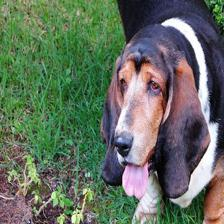

In [ ]:
display((Image.fromarray((x_train[4]*255.0).astype('uint8')) )) # this is how you display an image

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

base_model = VGG16(weights="imagenet", include_top=False, input_shape=(image_shape, image_shape, 3))

In [ ]:
for layer in base_model.layers:
    layer.trainable = False



In [ ]:
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(37, activation='softmax')(x)

In [ ]:
batch_size = 16
train_generator = DataGenerator(x_train, y_train, batch_size, augment=True)
test_generator = DataGenerator(x_test, y_test, batch_size, augment=False)

In [ ]:
model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='SparseCategoricalCrossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │          65,6

 Total params: 14,785,125 (56.40 MB)

 Trainable params: 70,437 (275.14 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


history = model.fit(train_generator, epochs=40, validation_data=test_generator, callbacks=[early_stopping])

Epoch 1/40


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


369/369 ━━━━━━━━━━━━━━━━━━━━ 46s 117ms/step - accuracy: 0.0302 - loss: 3.7905 - val_accuracy: 0.0591 - val_loss: 3.5624
Epoch 2/40
369/369 ━━━━━━━━━━━━━━━━━━━━ 44s 118ms/step - accuracy: 0.0515 - loss: 3.5665 - val_accuracy: 0.1087 - val_loss: 3.5032
Epoch 3/40
369/369 ━━━━━━━━━━━━━━━━━━━━ 45s 121ms/step - accuracy: 0.0704 - loss: 3.5040 - val_accuracy: 0.1365 - val_loss: 3.4336
Epoch 4/40
369/369 ━━━━━━━━━━━━━━━━━━━━ 46s 124ms/step - accuracy: 0.0941 - loss: 3.4362 - val_accuracy: 0.1787 - val_loss: 3.3533
Epoch 5/40
369/369 ━━━━━━━━━━━━━━━━━━━━ 46s 126ms/step - accuracy: 0.1102 - loss: 3.3564 - val_accuracy: 0.1990 - val_loss: 3.2676
Epoch 6/40
369/369 ━━━━━━━━━━━━━━━━━━━━ 47s 128ms/step - accuracy: 0.1269 - loss: 3.2803 - val_accuracy: 0.2276 - val_loss: 3.1830
Epoch 7/40
369/369 ━━━━━━━━━━━━━━━━━━━━ 47s 126ms/step - accuracy: 0.1336 - loss: 3.2024 - val_accuracy: 0.2636 - val_loss: 3.0971
Epoch 8/40
369/369 ━━━━━━━━━━━━━━━━━━━━ 46s 126ms/step - accuracy: 0.1610 - loss: 3.1206 - val

In [ ]:

for layer in base_model.layers[-10:]:
    layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss="SparseCategoricalCrossentropy",
              metrics=["accuracy"])


history_finetune = model.fit(train_generator, validation_data=test_generator, epochs=30, callbacks=[early_stopping])


Epoch 1/30
369/369 ━━━━━━━━━━━━━━━━━━━━ 81s 186ms/step - accuracy: 0.4755 - loss: 1.6472 - val_accuracy: 0.6712 - val_loss: 1.0788
Epoch 2/30
369/369 ━━━━━━━━━━━━━━━━━━━━ 70s 191ms/step - accuracy: 0.6038 - loss: 1.2017 - val_accuracy: 0.7106 - val_loss: 0.9283
Epoch 3/30
369/369 ━━━━━━━━━━━━━━━━━━━━ 72s 196ms/step - accuracy: 0.6588 - loss: 1.0245 - val_accuracy: 0.7289 - val_loss: 0.8664
Epoch 4/30
369/369 ━━━━━━━━━━━━━━━━━━━━ 82s 196ms/step - accuracy: 0.6785 - loss: 0.9222 - val_accuracy: 0.7656 - val_loss: 0.7684
Epoch 5/30
369/369 ━━━━━━━━━━━━━━━━━━━━ 72s 196ms/step - accuracy: 0.7399 - loss: 0.7663 - val_accuracy: 0.7779 - val_loss: 0.7453
Epoch 6/30
369/369 ━━━━━━━━━━━━━━━━━━━━ 72s 196ms/step - accuracy: 0.7679 - loss: 0.6821 - val_accuracy: 0.7955 - val_loss: 0.6811
Epoch 7/30
369/369 ━━━━━━━━━━━━━━━━━━━━ 72s 196ms/step - accuracy: 0.7664 - loss: 0.6577 - val_accuracy: 0.7914 - val_loss: 0.6707
Epoch 8/30
369/369 ━━━━━━━━━━━━━━━━━━━━ 72s 196ms/step - accuracy: 0.8138 - loss: 0

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - accuracy: 0.8341 - loss: 0.6145
Test Loss: 0.5755457282066345
Test Accuracy: 0.8410326242446899


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step


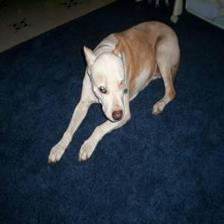

Pred: pug
True: pug


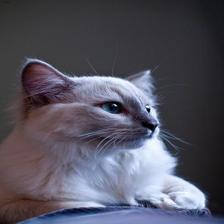

Pred: saint bernard
True: saint bernard


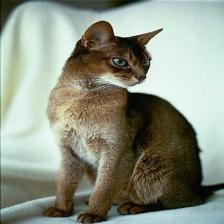

Pred: great pyrenees
True: great pyrenees


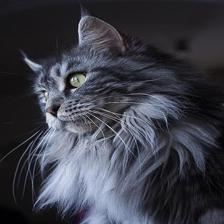

Pred: basset hound
True: basset hound


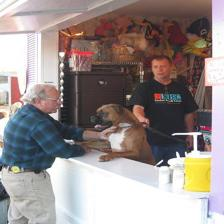

Pred: english cocker spaniel
True: english cocker spaniel


In [ ]:
import random
import matplotlib.pyplot as plt
random_indices = random.sample(range(len(x_test)), 5)

selected_images = x_test[random_indices]
selected_labels = y_test[random_indices]


predictions = model.predict(selected_images)
predicted_labels = np.argmax(predictions, axis=1)
image=0
for i in random_indices:
    display(Image.fromarray((x_train[i]*255.0).astype('uint8')) )

    print(f"Pred: {class_breeds[predicted_labels[image]]}\nTrue: {class_breeds[y_test[i]]}")
    image+=1



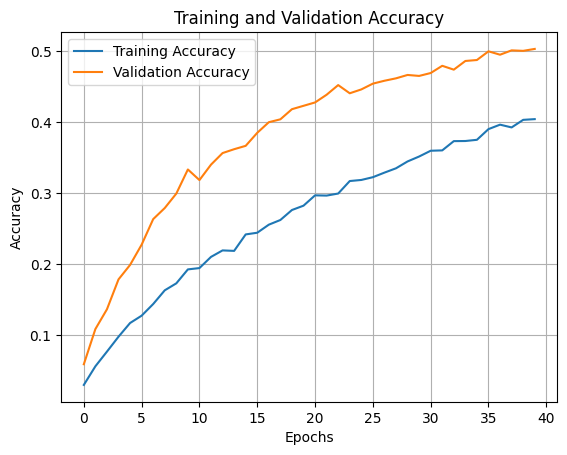

In [ ]:
#plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

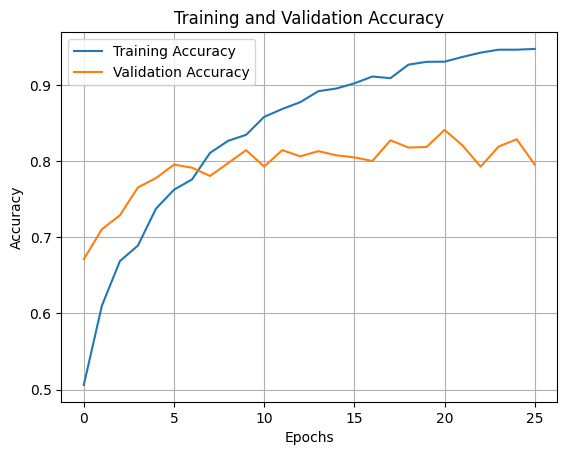

In [ ]:
#plot training and validation accuracy
plt.plot(history_finetune.history['accuracy'], label='Training Accuracy')
plt.plot(history_finetune.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

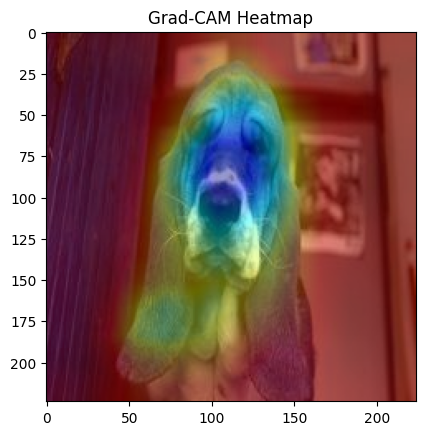

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from PIL import Image

# Function to apply Grad-CAM
def compute_gradcam(model, img_array, layer_name):
    grad_model = tf.keras.models.Model(
        inputs=model.input,
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_idx = np.argmax(predictions[0])  # Predicted class
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))


    heatmap = np.mean(conv_outputs[0] * pooled_grads, axis=-1)
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)

    return heatmap


def overlay_heatmap(img, heatmap, alpha=0.4):
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    overlayed_img = cv2.addWeighted(img, 1 - alpha, heatmap, alpha, 0)
    return overlayed_img


def visualize_gradcam(model, image_array, layer_name="block5_conv3"):

    img = (image_array * 255).astype('uint8')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


    img_array = tf.image.resize(img, (224, 224)) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    heatmap = compute_gradcam(model, img_array, layer_name)

    overlayed_img = overlay_heatmap(img, heatmap)


    plt.imshow(overlayed_img)
    plt.title("Grad-CAM Heatmap")
    plt.show()

visualize_gradcam(model, x_train[15])


In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 13.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=fe168e942822d598b97fef257f874f54d4a54563e60181f749bc57dbefd1764b
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


  0%|          | 0/1000 [00:00<?, ?it/s]

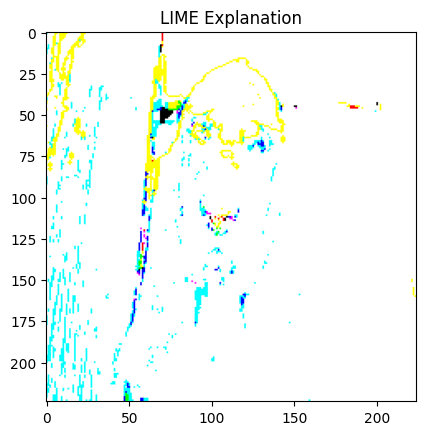

In [ ]:
import sys
import os
from lime import lime_image
from contextlib import redirect_stdout
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
import cv2


explainer = lime_image.LimeImageExplainer()

def suppress_lime_output(func):       # this is to avoid having green bar
    with open(os.devnull, 'w') as fnull:
        with redirect_stdout(fnull):
            return func()

# Function to visualize lime explanation
def visualize_lime(model, image_array):
    img = (image_array * 255).astype('uint8')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img_resized = tf.image.resize(img, (224, 224)).numpy()


    explanation = suppress_lime_output(lambda: explainer.explain_instance(
        img_resized,
        model.predict,
        top_labels=1,
        hide_color=0,
        num_samples=1000
    ))

    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False, )
    plt.imshow(mark_boundaries(temp, mask))
    plt.title("LIME Explanation")
    plt.show()


visualize_lime(model, x_train[15])


47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 152ms/step


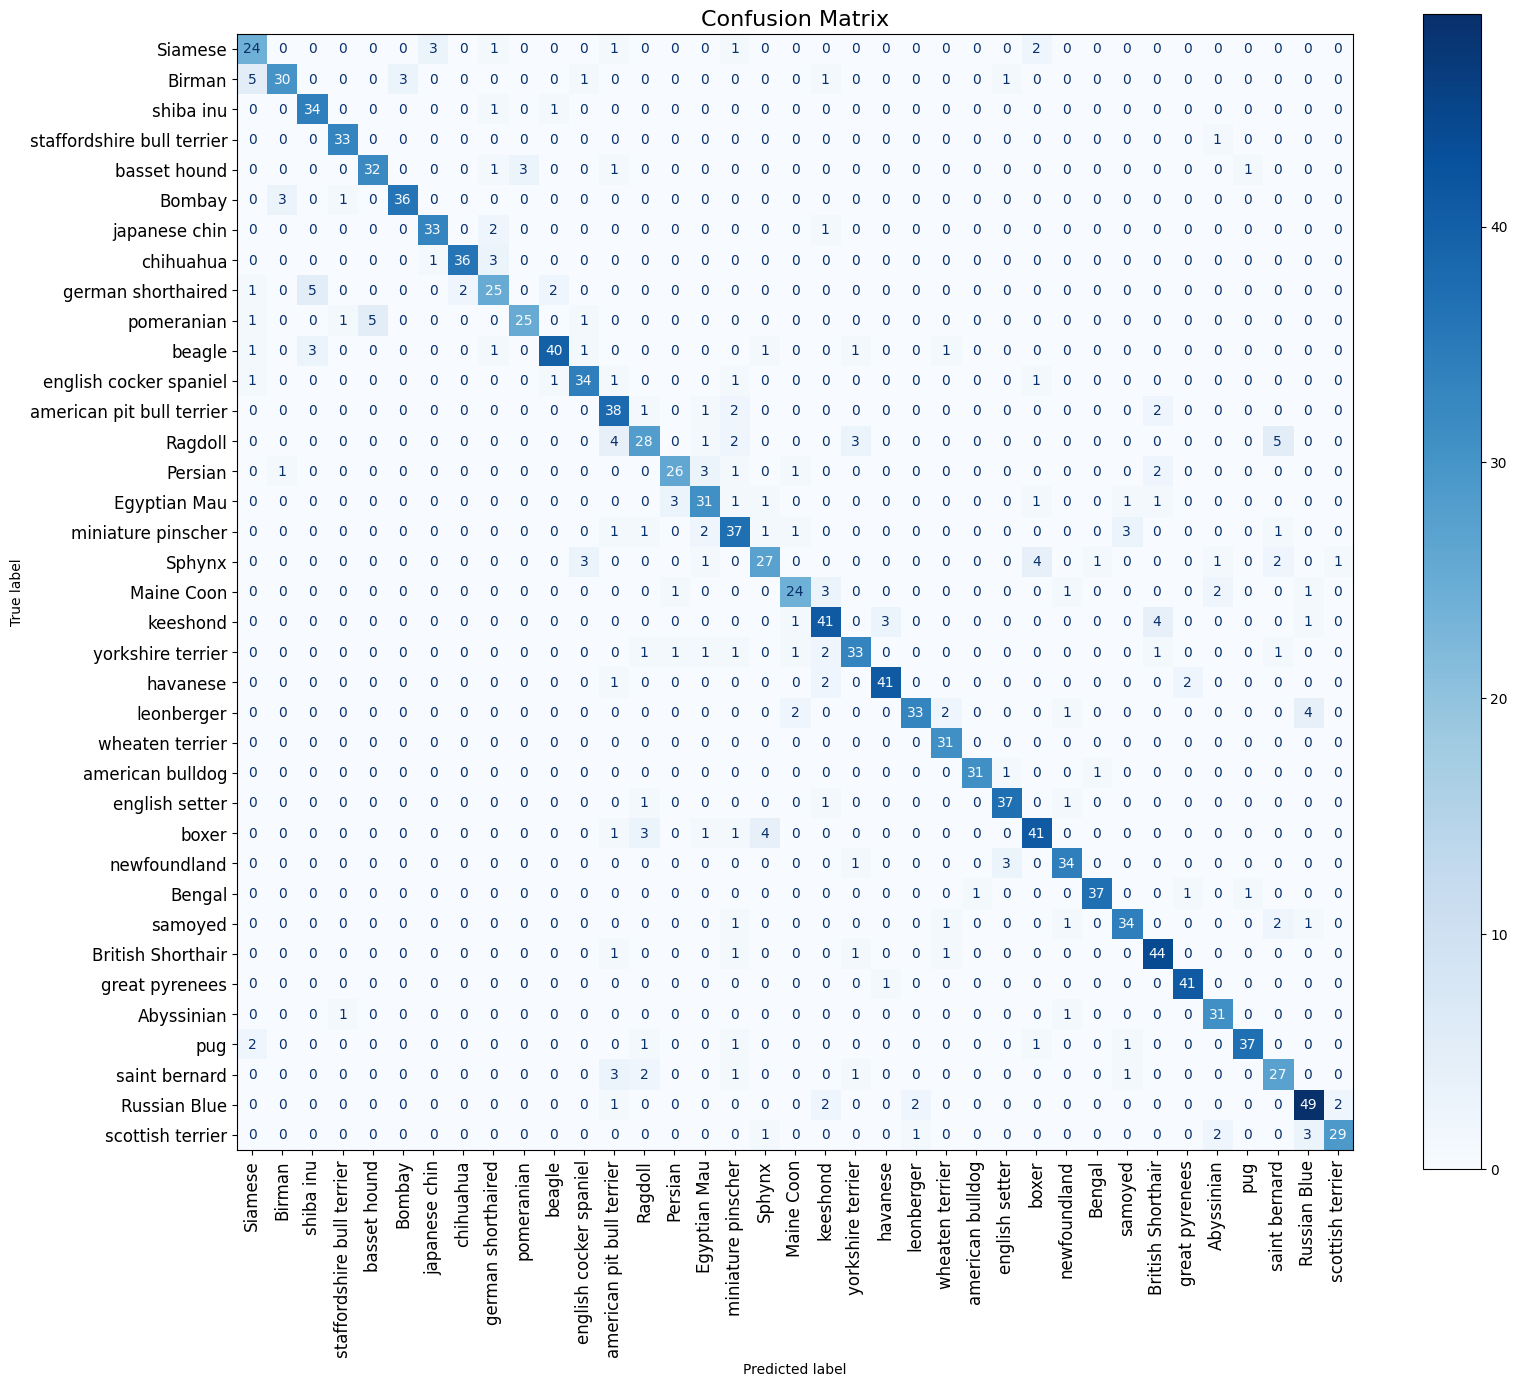

In [ ]:
# confusion matrix
y_pred = np.argmax(model.predict(x_test), axis=-1)

cm = confusion_matrix(y_test, y_pred)


fig, ax = plt.subplots(figsize=(18, 15))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_breeds)
disp.plot(cmap=plt.cm.Blues, ax=ax)

plt.title('Confusion Matrix', fontsize=16)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [ ]:
# due to high precision (84%) we can see that there is not so much confusion. We observe some wrong answers (5) between Birman and Siamese breeds, which makes sense given their similar appearance

report :

At first, I had to figure out how to handle the image data and work with byte strings
I found that using PIL worked well and was easy to diplay

I struggled a lot at first because I didn't have a good GPU on Google Colab

My first approach:
-reduced image size to 32x32 pixels
-simplified the model to just one layer
-freed up memory from unused variables
-increased batch size

however model.fit kept crashing so I had to found more tricks

I switched to a data generator as suggested, in order to charge data one batch at the time, this allowed the model to compile, but training was very slow and the accuracy was poor

After upgrading to a T4 GPU on Colab everything improved


-went back to 224x224 pixels which is a better size for VGG
-reduced batch size

The model worked better and trained faster
but overfitted quickly and lacked precision

Fixing :

-I added dropout layer to prevent overfitting
-used data augmentation
-used early stopping when overfitting occurred

the model was performing better but I tried to do more.

Fine-Tuning the Model:
-I then tried unfreezing layers after a few epochs
-lowering the Adam learning rate
-testing different training strategies

The best setup was 40 epochs with frozen layers Unfreeze & fine-tune for 30 more epochs (more like 25 with early stopping)


With this, the model's accuracy jumped to around 80%

after this I did the LIME and Grad-CAM + confusion matrix
to visualize model it was very interesting